# mlbox do some hyper param analysis

In [1]:
import pandas as pd
import numpy as np
import os
import os.path
import sys
import tempfile
import shutil

import mlflow
import tempfile

In [2]:
from mlbox.preprocessing import *
from mlbox.optimisation import *
from mlbox.prediction import *

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
sys.path.append('..')
from utils.kaggle import get_global_parameters
from utils.mlflow_experiments import retrieve_artifacts, extract_run_data_for_experiment
global_parms = get_global_parameters()

In [4]:
global_parms

{'PROJ_DIR': '/opt/project'}

In [5]:
TMPDIR= tempfile.mkdtemp()

In [6]:
MLBOX_SAVE='mlbox_save'

## Retrieve training data

In [7]:
# retrieve run_id for desired feature set to test
run_info = extract_run_data_for_experiment('feature_set')
RUN_ID = run_info.loc[run_info['mlflow.runName'] == 'feature_set_0'].run_id.values[0]

retrieve_artifacts(RUN_ID, '.', TMPDIR)

In [8]:
os.listdir(TMPDIR)

['fs_test_df.pkl', 'fs_valid_df.pkl', 'kag_test_df.pkl', 'fs_train_df.pkl']

In [9]:
pd.read_pickle(os.path.join(TMPDIR,'fs_train_df.pkl')) \
    .sample(10000).drop(['TransactionID', 'TransactionDT', 'addr1'], axis=1) \
    .to_csv(os.path.join(TMPDIR,'fs_train_df.csv'),index=False)

In [10]:
pd.read_pickle(os.path.join(TMPDIR,'fs_test_df.pkl')) \
    .sample(10000).drop(['isFraud', 'TransactionID', 'TransactionDT', 'addr1'], axis=1) \
    .to_csv(os.path.join(TMPDIR,'fs_test_df.csv'),index=False)

In [11]:
paths = [os.path.join(TMPDIR,'fs_test_df.csv'), os.path.join(TMPDIR,'fs_train_df.csv')]

In [12]:
rd = Reader(sep=',', to_path=MLBOX_SAVE)
df = rd.train_test_split(paths, 'isFraud')



reading csv : fs_test_df.csv ...
cleaning data ...
CPU time: 1.1822774410247803 seconds

reading csv : fs_train_df.csv ...
cleaning data ...
CPU time: 1.098987102508545 seconds

> Number of common features : 131

gathering and crunching for train and test datasets ...
reindexing for train and test datasets ...
dropping training duplicates ...
dropping constant variables on training set ...

> Number of categorical features: 18
> Number of numerical features: 112
> Number of training samples : 7360
> Number of test samples : 10000

> Top sparse features (% missing values on train set):
D7       90.5
id_04    84.2
D8       82.2
D9       82.2
id_10    82.2
dtype: float64

> Task : classification
0.0    7024
1.0     336
Name: isFraud, dtype: int64

encoding target ...


In [13]:
dft = Drift_thresholder(to_path=MLBOX_SAVE)
df = dft.fit_transform(df)


computing drifts ...
CPU time: 1.9879446029663086 seconds

> Top 10 drifts

('V283', 0.16061442934782622)
('D3', 0.11513809782608697)
('id_28', 0.09332983695652164)
('id_29', 0.09280122282608705)
('id_16', 0.0873452173913043)
('V308', 0.0869275815217394)
('D5', 0.08465845108695635)
('id_15', 0.08333782608695661)
('V128', 0.07684209239130424)
('V171', 0.058819673913043324)

> Deleted variables : []
> Drift coefficients dumped into directory : mlbox_save


In [14]:
opt = Optimiser(scoring = 'roc_auc', n_folds = 3, to_path=MLBOX_SAVE)


/opt/conda/lib/python3.6/site-packages/mlbox/optimisation/optimiser.py:77: UserWarning: Optimiser will save all your fitted models into directory 'mlbox_save/joblib'. Please clear it regularly.
  +str(self.to_path)+"/joblib'. Please clear it regularly.")


In [15]:
opt.evaluate(None, df)


No parameters set. Default configuration is tested

##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'label_encoding'}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}


MEAN SCORE : roc_auc = 0.7840426481574309
VARIANCE : 0.010612051969738998 (fold 1 = 0.7845534189337562, fold 2 = 0.7967767895282847, fold 3 = 0.770797736010252)
CPU time: 4.5573241710

0.7840426481574309

In [16]:
space = {
    
        'ne__numerical_strategy':{"search":"choice",
                                 "space":[0]},
        'ce__strategy':{"search":"choice",
                        "space":["label_encoding","random_projection", "entity_embedding"]}, 
        'fs__threshold':{"search":"uniform",
                        "space":[0.01,0.3]},    
        'est__max_depth':{"search":"choice",
                                  "space":[3,4,5,6,7]},
        'est__n_estimators': {'search':'choice', 'space':[250, 500, 750, 1000, 1500]}
    
        }

best = opt.optimise(space, df)


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'entity_embedding'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.0883501259831483}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 4, 'n_estimators': 750, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))



MEAN SCORE : roc_auc = 0.8030083692055509
VARIANCE : 0.006954818373136833 (fold 1 = 0.8115087837013542, fold 2 = 0.8030431897235614, fold 3 = 0.7944731341917374)
CPU time: 29.749992847442627 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'random_projection'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.03730366496882779}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 4, 'n_estimators': 250, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsampl

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))



MEAN SCORE : roc_auc = 0.8369899342109184
VARIANCE : 0.009181934343491193 (fold 1 = 0.8330848938636086, fold 2 = 0.8496674192957833, fold 3 = 0.8282174894733632)
CPU time: 3.0492794513702393 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'random_projection'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.2325236953221319}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 7, 'n_estimators': 500, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))



MEAN SCORE : roc_auc = 0.8058022078126817
VARIANCE : 0.005714654438850735 (fold 1 = 0.8109159601073564, fold 2 = 0.808665024104473, fold 3 = 0.797825639226216)
CPU time: 4.245685577392578 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'entity_embedding'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.1724371104580813}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 4, 'n_estimators': 1500, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_fr

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))



MEAN SCORE : roc_auc = 0.7776709963034545
VARIANCE : 0.011866427655444683 (fold 1 = 0.7871286751250457, fold 2 = 0.7849476719350705, fold 3 = 0.7609366418502472)
CPU time: 9.167195796966553 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'label_encoding'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.09669291407545565}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 5, 'n_estimators': 750, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_fr

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))



MEAN SCORE : roc_auc = 0.7987899295394483
VARIANCE : 0.008600389478573755 (fold 1 = 0.8036819873124315, fold 2 = 0.8059875968755721, fold 3 = 0.786700204430341)
CPU time: 4.3751232624053955 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'random_projection'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.1216389473690671}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 3, 'n_estimators': 500, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))



MEAN SCORE : roc_auc = 0.8284973143650194
VARIANCE : 0.00862425300512002 (fold 1 = 0.8294326430401366, fold 2 = 0.8385610544944163, fold 3 = 0.8174982455605053)
CPU time: 3.5245988368988037 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'label_encoding'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.13743274434586933}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 7, 'n_estimators': 250, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_fr

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))



MEAN SCORE : roc_auc = 0.8257053472012722
VARIANCE : 0.005949988715300756 (fold 1 = 0.8258108911796999, fold 2 = 0.8329392201135046, fold 3 = 0.8183659303106121)
CPU time: 3.327993154525757 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'entity_embedding'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.2823045397225285}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 6, 'n_estimators': 250, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_f

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))



MEAN SCORE : roc_auc = 0.8302321377674682
VARIANCE : 0.004255029964711989 (fold 1 = 0.8332678876418202, fold 2 = 0.8332138280344175, fold 3 = 0.8242146976261671)
CPU time: 6.8717567920684814 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'entity_embedding'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.137807618783298}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 6, 'n_estimators': 750, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_f

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))



MEAN SCORE : roc_auc = 0.7952706483647006
VARIANCE : 0.008134472099204175 (fold 1 = 0.8053079632792486, fold 2 = 0.7951196070055532, fold 3 = 0.7853843748093)
CPU time: 8.021548986434937 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'random_projection'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.2930936981676334}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 3, 'n_estimators': 1000, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_fr

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))



MEAN SCORE : roc_auc = 0.8042597272627517
VARIANCE : 0.009831933011654337 (fold 1 = 0.8133997194095401, fold 2 = 0.8087641880759138, fold 3 = 0.790615274302801)
CPU time: 4.728214979171753 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'entity_embedding'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.19749159347922884}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 6, 'n_estimators': 500, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_f

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))



MEAN SCORE : roc_auc = 0.8061796118522957
VARIANCE : 0.008008991165330694 (fold 1 = 0.8166573898987435, fold 2 = 0.8046660462561785, fold 3 = 0.7972153994019651)
CPU time: 7.569471120834351 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'entity_embedding'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.13466611574913442}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 3, 'n_estimators': 1500, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))



MEAN SCORE : roc_auc = 0.7885184122387496
VARIANCE : 0.013061894385582695 (fold 1 = 0.8066194186897645, fold 2 = 0.7826592725941295, fold 3 = 0.7762765454323549)
CPU time: 9.3834547996521 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'entity_embedding'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.025386195035584626}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 4, 'n_estimators': 500, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_f

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))



MEAN SCORE : roc_auc = 0.8190885590633545
VARIANCE : 0.004269364603468275 (fold 1 = 0.8222996980602659, fold 2 = 0.8219110422896199, fold 3 = 0.813054936840178)
CPU time: 7.387026071548462 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'entity_embedding'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.08693283041142051}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 6, 'n_estimators': 500, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_f

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))



MEAN SCORE : roc_auc = 0.8061796118522957
VARIANCE : 0.008008991165330694 (fold 1 = 0.8166573898987435, fold 2 = 0.8046660462561785, fold 3 = 0.7972153994019651)
CPU time: 7.490747928619385 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'entity_embedding'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.04164255735919761}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 4, 'n_estimators': 1500, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))



MEAN SCORE : roc_auc = 0.7776709963034545
VARIANCE : 0.011866427655444683 (fold 1 = 0.7871286751250457, fold 2 = 0.7849476719350705, fold 3 = 0.7609366418502472)
CPU time: 9.063817262649536 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'label_encoding'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.02464366046275205}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 6, 'n_estimators': 250, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_fr

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))



MEAN SCORE : roc_auc = 0.8290756316264458
VARIANCE : 0.005913575602939334 (fold 1 = 0.8348748017567402, fold 2 = 0.8313945505583694, fold 3 = 0.8209575425642277)
CPU time: 3.1225197315216064 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'random_projection'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.2740329643156525}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 5, 'n_estimators': 500, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))



MEAN SCORE : roc_auc = 0.8109963293045345
VARIANCE : 0.003048392044176282 (fold 1 = 0.8147435799682812, fold 2 = 0.8109686794410202, fold 3 = 0.8072767285043021)
CPU time: 3.8938629627227783 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'random_projection'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.16945184195195093}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 6, 'n_estimators': 1000, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsamp

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))



MEAN SCORE : roc_auc = 0.7923933664533919
VARIANCE : 0.008875065170287045 (fold 1 = 0.7937088263999024, fold 2 = 0.8025454628669066, fold 3 = 0.7809258100933667)
CPU time: 5.867981433868408 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'random_projection'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.01397268847021554}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 5, 'n_estimators': 250, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))



MEAN SCORE : roc_auc = 0.8330710438254681
VARIANCE : 0.004050906984239404 (fold 1 = 0.8331306423081615, fold 2 = 0.8380023036553366, fold 3 = 0.8280801855129065)
CPU time: 3.3179337978363037 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'label_encoding'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.04584541279727424}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 4, 'n_estimators': 1000, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))



MEAN SCORE : roc_auc = 0.7943465516069294
VARIANCE : 0.007075890049722877 (fold 1 = 0.8041680645358058, fold 2 = 0.7910958381643987, fold 3 = 0.7877757521205834)
CPU time: 4.482501029968262 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'random_projection'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.010986415488723839}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 5, 'n_estimators': 250, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsampl

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))



MEAN SCORE : roc_auc = 0.8330710438254681
VARIANCE : 0.004050906984239404 (fold 1 = 0.8331306423081615, fold 2 = 0.8380023036553366, fold 3 = 0.8280801855129065)
CPU time: 3.406207799911499 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'random_projection'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.07320473509345293}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 5, 'n_estimators': 250, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))



MEAN SCORE : roc_auc = 0.8330710438254681
VARIANCE : 0.004050906984239404 (fold 1 = 0.8331306423081615, fold 2 = 0.8380023036553366, fold 3 = 0.8280801855129065)
CPU time: 3.7286531925201416 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'random_projection'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.06430380224792924}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 5, 'n_estimators': 250, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsampl

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))



MEAN SCORE : roc_auc = 0.8330710438254681
VARIANCE : 0.004050906984239404 (fold 1 = 0.8331306423081615, fold 2 = 0.8380023036553366, fold 3 = 0.8280801855129065)
CPU time: 3.5158984661102295 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'random_projection'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.0537952942044906}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 5, 'n_estimators': 250, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))



MEAN SCORE : roc_auc = 0.8330710438254681
VARIANCE : 0.004050906984239404 (fold 1 = 0.8331306423081615, fold 2 = 0.8380023036553366, fold 3 = 0.8280801855129065)
CPU time: 3.817937135696411 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'random_projection'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.04621231331769443}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 4, 'n_estimators': 250, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))



MEAN SCORE : roc_auc = 0.8369899342109184
VARIANCE : 0.009181934343491193 (fold 1 = 0.8330848938636086, fold 2 = 0.8496674192957833, fold 3 = 0.8282174894733632)
CPU time: 3.49422025680542 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'random_projection'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.11384376225398529}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 4, 'n_estimators': 250, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))



MEAN SCORE : roc_auc = 0.8369899342109184
VARIANCE : 0.009181934343491193 (fold 1 = 0.8330848938636086, fold 2 = 0.8496674192957833, fold 3 = 0.8282174894733632)
CPU time: 3.5365960597991943 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'random_projection'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.1121271403205058}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 4, 'n_estimators': 250, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))



MEAN SCORE : roc_auc = 0.8369899342109184
VARIANCE : 0.009181934343491193 (fold 1 = 0.8330848938636086, fold 2 = 0.8496674192957833, fold 3 = 0.8282174894733632)
CPU time: 3.5757946968078613 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'random_projection'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.21005771676377352}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 4, 'n_estimators': 250, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsampl

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))



MEAN SCORE : roc_auc = 0.8369899342109184
VARIANCE : 0.009181934343491193 (fold 1 = 0.8330848938636086, fold 2 = 0.8496674192957833, fold 3 = 0.8282174894733632)
CPU time: 3.3905553817749023 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'random_projection'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.2220547928960437}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 4, 'n_estimators': 750, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))



MEAN SCORE : roc_auc = 0.8026782905627826
VARIANCE : 0.0044609136373627315 (fold 1 = 0.8082225204343052, fold 2 = 0.8025130438762433, fold 3 = 0.7972993073777995)
CPU time: 4.706212282180786 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'label_encoding'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.09995937125405241}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 7, 'n_estimators': 250, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_f

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))



MEAN SCORE : roc_auc = 0.8257053472012722
VARIANCE : 0.005949988715300756 (fold 1 = 0.8258108911796999, fold 2 = 0.8329392201135046, fold 3 = 0.8183659303106121)
CPU time: 3.7056729793548584 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'random_projection'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.2495984272426226}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 4, 'n_estimators': 1000, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsampl

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))



MEAN SCORE : roc_auc = 0.7929883027834735
VARIANCE : 0.004623290794176871 (fold 1 = 0.7985066945223862, fold 2 = 0.793266003539391, fold 3 = 0.7871922102886435)
CPU time: 5.253749847412109 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'random_projection'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.19960249289293727}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 4, 'n_estimators': 1500, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))



MEAN SCORE : roc_auc = 0.7801631373377815
VARIANCE : 0.0076046560134668964 (fold 1 = 0.7892864767597901, fold 2 = 0.7805329682065052, fold 3 = 0.7706699670470495)
CPU time: 6.576830863952637 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'random_projection'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.24207576734518}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 7, 'n_estimators': 750, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_f

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))



MEAN SCORE : roc_auc = 0.7960995319457943
VARIANCE : 0.007687603240700867 (fold 1 = 0.8010228589727949, fold 2 = 0.8020324800146458, fold 3 = 0.7852432568499421)
CPU time: 5.768770217895508 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'label_encoding'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.20546815540772728}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 4, 'n_estimators': 250, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_fr

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))



MEAN SCORE : roc_auc = 0.8342222008140316
VARIANCE : 0.0061026737129537935 (fold 1 = 0.8333765401976332, fold 2 = 0.8420832824800146, fold 3 = 0.8272067797644473)
CPU time: 3.339336395263672 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'random_projection'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.16228080546887852}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 3, 'n_estimators': 1500, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsamp

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))



MEAN SCORE : roc_auc = 0.7881806844273901
VARIANCE : 0.011856912320213462 (fold 1 = 0.7990175521532268, fold 2 = 0.7938438243729786, fold 3 = 0.771680676755965)
CPU time: 5.976391792297363 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'random_projection'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.08387004258653682}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 4, 'n_estimators': 750, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))



MEAN SCORE : roc_auc = 0.8026782905627826
VARIANCE : 0.0044609136373627315 (fold 1 = 0.8082225204343052, fold 2 = 0.8025130438762433, fold 3 = 0.7972993073777995)
CPU time: 4.739107847213745 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'label_encoding'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.18412554943887638}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 7, 'n_estimators': 250, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_f

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))



MEAN SCORE : roc_auc = 0.8257053472012722
VARIANCE : 0.005949988715300756 (fold 1 = 0.8258108911796999, fold 2 = 0.8329392201135046, fold 3 = 0.8183659303106121)
CPU time: 3.528978109359741 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'random_projection'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.2621413966520993}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 4, 'n_estimators': 250, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))



MEAN SCORE : roc_auc = 0.8369899342109184
VARIANCE : 0.009181934343491193 (fold 1 = 0.8330848938636086, fold 2 = 0.8496674192957833, fold 3 = 0.8282174894733632)
CPU time: 3.3955585956573486 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'random_projection'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.2635593136182781}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 3, 'n_estimators': 1000, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsampl

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))



MEAN SCORE : roc_auc = 0.8042597272627517
VARIANCE : 0.009831933011654337 (fold 1 = 0.8133997194095401, fold 2 = 0.8087641880759138, fold 3 = 0.790615274302801)
CPU time: 4.64403223991394 seconds


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'random_projection'}

>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.10846312195687559}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 4, 'n_estimators': 250, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_f

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))



MEAN SCORE : roc_auc = 0.8369899342109184
VARIANCE : 0.009181934343491193 (fold 1 = 0.8330848938636086, fold 2 = 0.8496674192957833, fold 3 = 0.8282174894733632)
CPU time: 3.1449739933013916 seconds



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ BEST HYPER-PARAMETERS ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

{'ce__strategy': 'random_projection', 'est__max_depth': 4, 'est__n_estimators': 250, 'fs__threshold': 0.03730366496882779, 'ne__numerical_strategy': 0}


In [17]:
best

{'ce__strategy': 'random_projection',
 'est__max_depth': 4,
 'est__n_estimators': 250,
 'fs__threshold': 0.03730366496882779,
 'ne__numerical_strategy': 0}


fitting the pipeline ...


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


CPU time: 1.5469717979431152 seconds


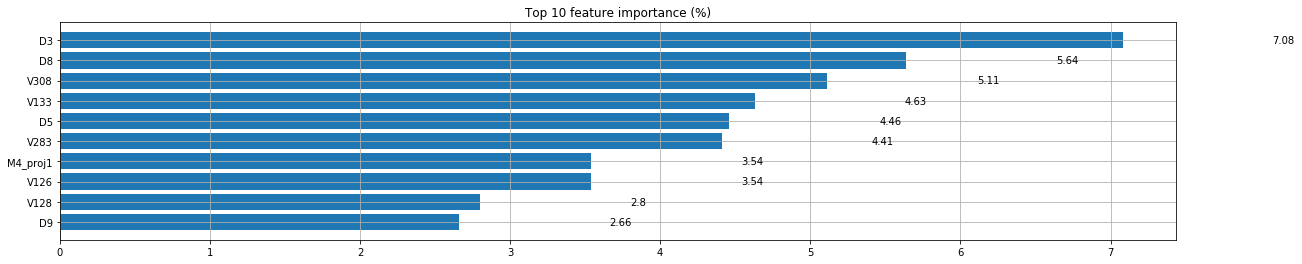


> Feature importances dumped into directory : mlbox_save

predicting ...
CPU time: 0.3346700668334961 seconds

> Overview on predictions : 

        0.0       1.0  isFraud_predicted
0  0.987332  0.012668                  0
1  0.974743  0.025257                  0
2  0.984448  0.015552                  0
3  0.971738  0.028262                  0
4  0.991478  0.008522                  0
5  0.912388  0.087612                  0
6  0.945331  0.054669                  0
7  0.989892  0.010108                  0
8  0.974743  0.025257                  0
9  0.998252  0.001748                  0

dumping predictions into directory : mlbox_save ...


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [19]:
%matplotlib inline
prd = Predictor(to_path=MLBOX_SAVE)
prd.fit_predict(best, df)

In [20]:
%%javascript
IPython.notebook.kernel.execute(`notebookName = '${IPython.notebook.notebook_name}'`);

<IPython.core.display.Javascript object>

In [22]:
notebookName

'automl_mlbox_hyperparm.ipynb'

In [25]:
# remove joblib artifacts from MLBOX_SAVE, these are not needed
shutil.rmtree(os.path.join(MLBOX_SAVE,'joblib'))

In [26]:
# save sample as mlflow artifact
experiment_id = mlflow.set_experiment('hyperparms')

#%%
with mlflow.start_run(experiment_id=experiment_id, run_name='mlbox_inital_hyperparm'):
    mlflow.log_param('notebook_name',notebookName)
    mlflow.log_artifacts(MLBOX_SAVE)


## Clean-up

In [17]:
shutil.rmtree(TMPDIR)

In [ ]:
pd.__version__